# CS Project 175 Phase 1

In [ ]:
!pip install pandas
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn
!pip install nltk

In [1]:
import pandas as pd
import numpy as np

from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import linear_model 
from sklearn import metrics 
from sklearn import preprocessing

import seaborn

# Analyzing the Data

In [2]:
data = pd.read_csv('./data/data.csv')
del data['Unnamed: 0']
data.head()

,title,genre,lyrics
0,the number of the beast,metal,woe to you o'er earth and sea\r\nfor the devil...
1,fear of the dark,metal,i am a man who walks alone\r\nand when i'm wal...
2,the trooper,metal,you'll take my life but i'll take yours too\r\...
3,hallowed be thy name,metal,i'm waiting in my cold cell when the bell begi...
4,run to the hills,metal,white man came across the sea\r\nhe brought us...


Num of rows 295288
biggest class:  118834
smallest class:  7630


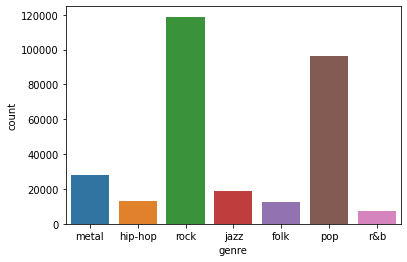

In [3]:
# plot labels
print('Num of rows', len(data))
seaborn.countplot(data, x='genre')
print('biggest class: ', (data['genre'] == data['genre'].value_counts().idxmax()).sum())
print('smallest class: ', (data['genre'] == data['genre'].value_counts().idxmin()).sum())


## Building the Pipeline

In [10]:
RANDOM_STATE = 42

def gather_data():
    data = pd.read_csv('./data/data.csv')
    return data['lyrics'], data['genre']

def vectorize_labels(labels, classes=None):
    '''
    Vectorizes the labels.
    Returns as (indexes, labels)
    '''
    if classes is None:
        return pd.factorize(labels)
    return pd.Categorical(labels, categories=classes).codes, classes

def features_bow(data):
    vectorizer = CountVectorizer(stop_words='english', min_df=0.01, ngram_range=(1, 2))
    text = data.to_list()
    X = vectorizer.fit_transform(text)
    return X, vectorizer

def train_model_logistic(X, Y):
    classifier = linear_model.LogisticRegression(penalty='l2', multi_class='multinomial', random_state=RANDOM_STATE, fit_intercept=True)
    classifier.fit(X, Y)
    return classifier

def evaluate_logistic_model(model, X_train, Y_train, X_test, Y_test):
    train_accuracy = model.score(X_train, Y_train)
    print('\nTraining:')
    print(' accuracy:',format( 100*train_accuracy , '.2f') ) 

    # Compute and print accuracy on the test data
    print('\nTesting: ')
    test_accuracy = model.score(X_test, Y_test)
    print(' accuracy:', format( 100*test_accuracy , '.2f') )

    # Compute and print AUC on the test data
    class_probabilities = model.predict_proba(X_test)
    test_auc_score = metrics.roc_auc_score(Y_test, class_probabilities, multi_class='ovo')
    print(' AUC value:', format( 100*test_auc_score , '.2f') )

## Executing the Pipeline

In [5]:
# Phase 1 pipeline
inputs, labels = gather_data()


In [6]:
# convert to features
Y, classes = vectorize_labels(labels)
X, vectorizer = features_bow(inputs)

In [7]:
# split into training and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=RANDOM_STATE)

In [11]:
# train model
model = train_model_logistic(X_train, Y_train)

c:\Users\luker\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Evaluating the Model

In [12]:
evaluate_logistic_model(model, X_train, Y_train, X_test, Y_test)


Training:
 accuracy: 57.30

Testing: 
 accuracy: 56.16
 AUC value: 81.16


In [ ]:
def most_significant_terms(weights, vectorizer, K):
    pos_indices = np.argpartition(weights, -K)[-K:] # gather the K most positive indices
    pos_indices = pos_indices[np.argsort(-weights[pos_indices])] # sort the indices

    neg_indices = np.argpartition(weights, K)[:K] # gather the K most negative indices
    neg_indices = neg_indices[np.argsort(weights[neg_indices])] # sort the indices

    topK_pos_weights = weights[pos_indices]
    topK_neg_weights = weights[neg_indices]

    # gather the associated terms
    terms = vectorizer.get_feature_names_out()
    topK_pos_terms = terms[pos_indices]
    topK_neg_terms = terms[neg_indices]
        
    # print the positive weights and terms
    print('Top positive weights:')
    for i in range(len(topK_pos_weights)):
        print(format(topK_pos_weights[i], '.3f'), topK_pos_terms[i])
    
    # print the negative weights and terms
    print('Most negative weights:')
    for i in range(len(topK_neg_weights)):
        print(format(topK_neg_weights[i], '.3f'), topK_neg_terms[i])



In [ ]:
classes

In [ ]:
for i in range(len(classes)):
    print('Most Significant Terms for Class: "' + classes[i] + '"')
    most_significant_terms(model.coef_[i], vectorizer, 5)
    print()

In [ ]:

predictions = model.predict(X_test)
probabilities = model.predict_proba(X_test)

np.random.seed(RANDOM_STATE)
NUM_EXAMPLES = 10
for _ in range(NUM_EXAMPLES):
    i = np.random.choice(np.where(predictions != Y_test)[0])
    print("Song Title:", data['title'][i])
    print('Predicted:', classes[predictions[i]], 'Actual:', classes[Y_test[i]])
    print('Probability:', probabilities[i][predictions[i]])
    print("Lyrics: ")
    print('"' + data['lyrics'][i][:100] + '..."')
    print()


<AxesSubplot:xlabel='genre', ylabel='count'>

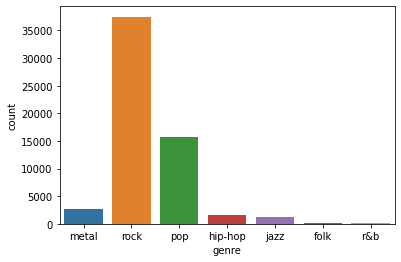

In [52]:
# Plot predictions to see distribution and if there is bias
test_predictions = [classes[i] for i in predictions]
test_predictions_df = pd.DataFrame(data=test_predictions, columns=["genre"])
seaborn.countplot(test_predictions_df, x="genre")

<AxesSubplot:xlabel='genre', ylabel='count'>

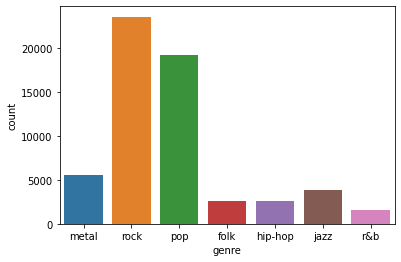

In [53]:
# Visualize the actual distribution of the test data
test_actuals = [classes[i] for i in Y_test]
seaborn.countplot(pd.DataFrame(data=test_actuals, columns=["genre"]), x="genre")

## Fixing the Skew

In [ ]:
min(np.bincount(Y))

In [54]:
from sklearn.utils import resample

def undersample(X, Y):
    return resample(X, Y, n_samples=min(np.bincount(Y)), random_state=RANDOM_STATE)

def oversample(X, Y):
    return resample(X, Y, n_samples=max(np.bincount(Y)), random_state=RANDOM_STATE)

def midsample(X, Y):
    return resample(X, Y, n_samples=(min(np.bincount(Y)) + max(np.bincount(Y))) // 2, random_state=RANDOM_STATE)

In [ ]:
undersampled_X_train, undersampled_Y_train = undersample(X_train, Y_train)
# train model
model = train_model_logistic(undersampled_X_train, undersampled_Y_train)
## Evaluating the Model
evaluate_logistic_model(model, undersampled_X_train, undersampled_Y_train, X_test, Y_test)

In [ ]:
oversampled_X_train, oversampled_Y_train = oversample(X_train, Y_train)
# train model
model = train_model_logistic(oversampled_X_train, oversampled_Y_train)
## Evaluating the Model
evaluate_logistic_model(model, oversampled_X_train, oversampled_Y_train, X_test, Y_test)

In [55]:
midsampled_X_train, midsampled_Y_train = midsample(X_train, Y_train)
# train model
model = train_model_logistic(midsampled_X_train, midsampled_Y_train)
## Evaluating the Model
evaluate_logistic_model(model, midsampled_X_train, midsampled_Y_train, X_test, Y_test)

c:\Users\luker\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Training:
 accuracy: 59.58

Testing: 
 accuracy: 54.59
 AUC value: 78.64
